**deepMISO**<br>
by $\text{Rishabh Pomaje}$

- Autoencoder based $2 \times 1$ MISO system with perfect CSI available exclusively at the receiver.
- Objectives :
    - To learn a (4, 7) code system under the following conditions :
    1. Flat-fading, fast fading 
    2. Rayleigh Channel with AWGN 
    3. Channel Model: $y_i = h_i x_i + w_i$
        - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times N_0}{2 \times E_b} = N_0/2 \;\dots (a = 1) 
\end{equation*}

Also, 

\begin{equation*}
\frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = \frac{nN_0}{2k}
\end{equation*}

In [35]:
# Dependencies :
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import time 
t0 = time.time()
%config InlineBackend.figure_format='svg'
TF_ENABLE_ONEDNN_OPTS=0
print(tf.__version__)

2.16.1


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

- System Specifications/ Parameters and Constants

In [36]:
k, n = 4, 7     # Uncoded and Coded block lengths
M = 2 ** k      # Size of the alphabet 
R = k / n       # Information rate

- Generation of training data  

In [37]:
training_set_size = 10 ** 6 

# Generating random labels :
sample_indices = np.random.randint(0, M, training_set_size)

# Converting to 1hot encoded vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1

# Since we wish to reproduce the inputs at the outputs:
y_train = x_train

print(f'Sample Input :{x_train[0]}')
print(f'Input shape :{np.shape(x_train)}')

# Generating the random fading taps for training == CSI @ Tx and Rx
fade_mean = 0
fade_std = np.sqrt(0.5)
fade_taps = np.random.normal(fade_mean, fade_std, (training_set_size, 2*n)) + 1j*np.random.normal(fade_mean, fade_std, (training_set_size, 2*n))

Sample Input :[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Input shape :(1000000, 16)


- Defining the Model 

1. We will use it to emulate the superposition of the two signal streams that have been independenly faded and subsequently arrive at the receiver. How does this make sense ? 
2. We will generate a tensor of length 14 corresponding to a input tensor representing a block of 4 bits. These 14 symbols we will interpret as pair of 7 coded bits for ever antenna ; The first 7 elements of the output of the encoder are from the first antenna and remaining from the other antenna. 
3. What we want implement to simulate a flat fading channel, is that multiply the elements in the 14 dimensional tensor with the channel taps. After that, we will split the vector in the middle, thereby getting 2 halves corresponding to the two antennas. Following this we get a 7 dimensional tensor which can be peturbed by AWGN simulating the imparity at the receiver.

In [38]:
# Custom Layer Class definition :
class SuperPoseLayer(tf.keras.layers.Layer):
    """ 
    Custom tensorflow layer that takes in an input (parent) tensor, splits it into halves and then performs elementwise
    addition along the last axis.(child tensors) and that is the output.
    """
    def __init__(self):
        super(SuperPoseLayer, self).__init__()

    def call(self, inputs):
        # Get the shape of the input tensor
        input_shape = tf.shape(inputs)
        
        # Split the input tensor into two halves along the last dimension
        split_size = input_shape[-1] // 2
        split1 = inputs[..., :split_size]
        split2 = inputs[..., split_size:]
        
        # Add the elements of each half
        added_splits = tf.math.add(split1, split2)
        
        return added_splits
# Demo 
demo_layer = SuperPoseLayer()
demo_input = tf.Variable([1, 2, 3, 4, 5, 6])
print(f'Demo Output :{demo_layer(demo_input)}')

Demo Output :[5 7 9]


In [39]:
# Description of the encoder(== transmitter) part :
enc_input_layer_bits = tf.keras.Input(shape=(M, ), name="Bits_Input_Layer")
fading_layer_real = tf.keras.Input(shape=(2*n, ), name='fading_taps_real')
fading_layer_imag = tf.keras.Input(shape=(2*n, ), name='fading_taps_imag')

enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Enc_Hidden_Layer_01")(enc_input_layer_bits)
enc_layer_02 = tf.keras.layers.Dense(2*n, activation='relu', name="Enc_Hidden_Layer_02")(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(2*n, activation='linear', name="Enc_Hidden_Layer_03")(enc_layer_02)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Describing the channel part :
# y = fx + w  model(flat + fast fading):
faded_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
faded_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Superposition of the signals of both the antennas at the receiver  :
rx_signal_real = SuperPoseLayer()(faded_signal_real)
rx_signal_imag = SuperPoseLayer()(faded_signal_imag)

# Noise at the receiver :
SNR_train = float(input('Enter training SNR')) 
SNR_lin = 10 ** (SNR_train / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_real')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_imag')(rx_signal_imag)

# Description of the Decoder (==Receiver) part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag, fading_layer_real, fading_layer_imag])
dec_layer_01 = tf.keras.layers.Dense(4*n, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_03)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer_bits, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Bits_Input_Layer    │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_01 │ (None, 16)        │        272 │ Bits_Input_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_02 │ (None, 14)        │        238 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_03 │ (None, 14)        │        210 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 14)        │          0 │ Enc_Hidden_Layer… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_real    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 14)        │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_real… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 14)        │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ super_pose_layer_7  │ (None, 7)         │          0 │ multiply_4[0][0]  │
│ (SuperPoseLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ super_pose_layer_8  │ (None, 7)         │          0 │ multiply_5[0][0]  │
│ (SuperPoseLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_real   │ (None, 7)         │          0 │ super_pose_layer… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_imag   │ (None, 7)         │          0 │ super_pose_layer… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 42)        │          0 │ AWGN_channel_rea… │
│ (Concatenate)       │                   │            │ AWGN_channel_ima… │
│                     │                   │            │ fading_taps_real… │
│                     │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 28)        │      1,204 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 32)        │        928 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                 

 Total params: 3,652 (14.27 KB)

 Trainable params: 3,652 (14.27 KB)

 Non-trainable params: 0 (0.00 B)

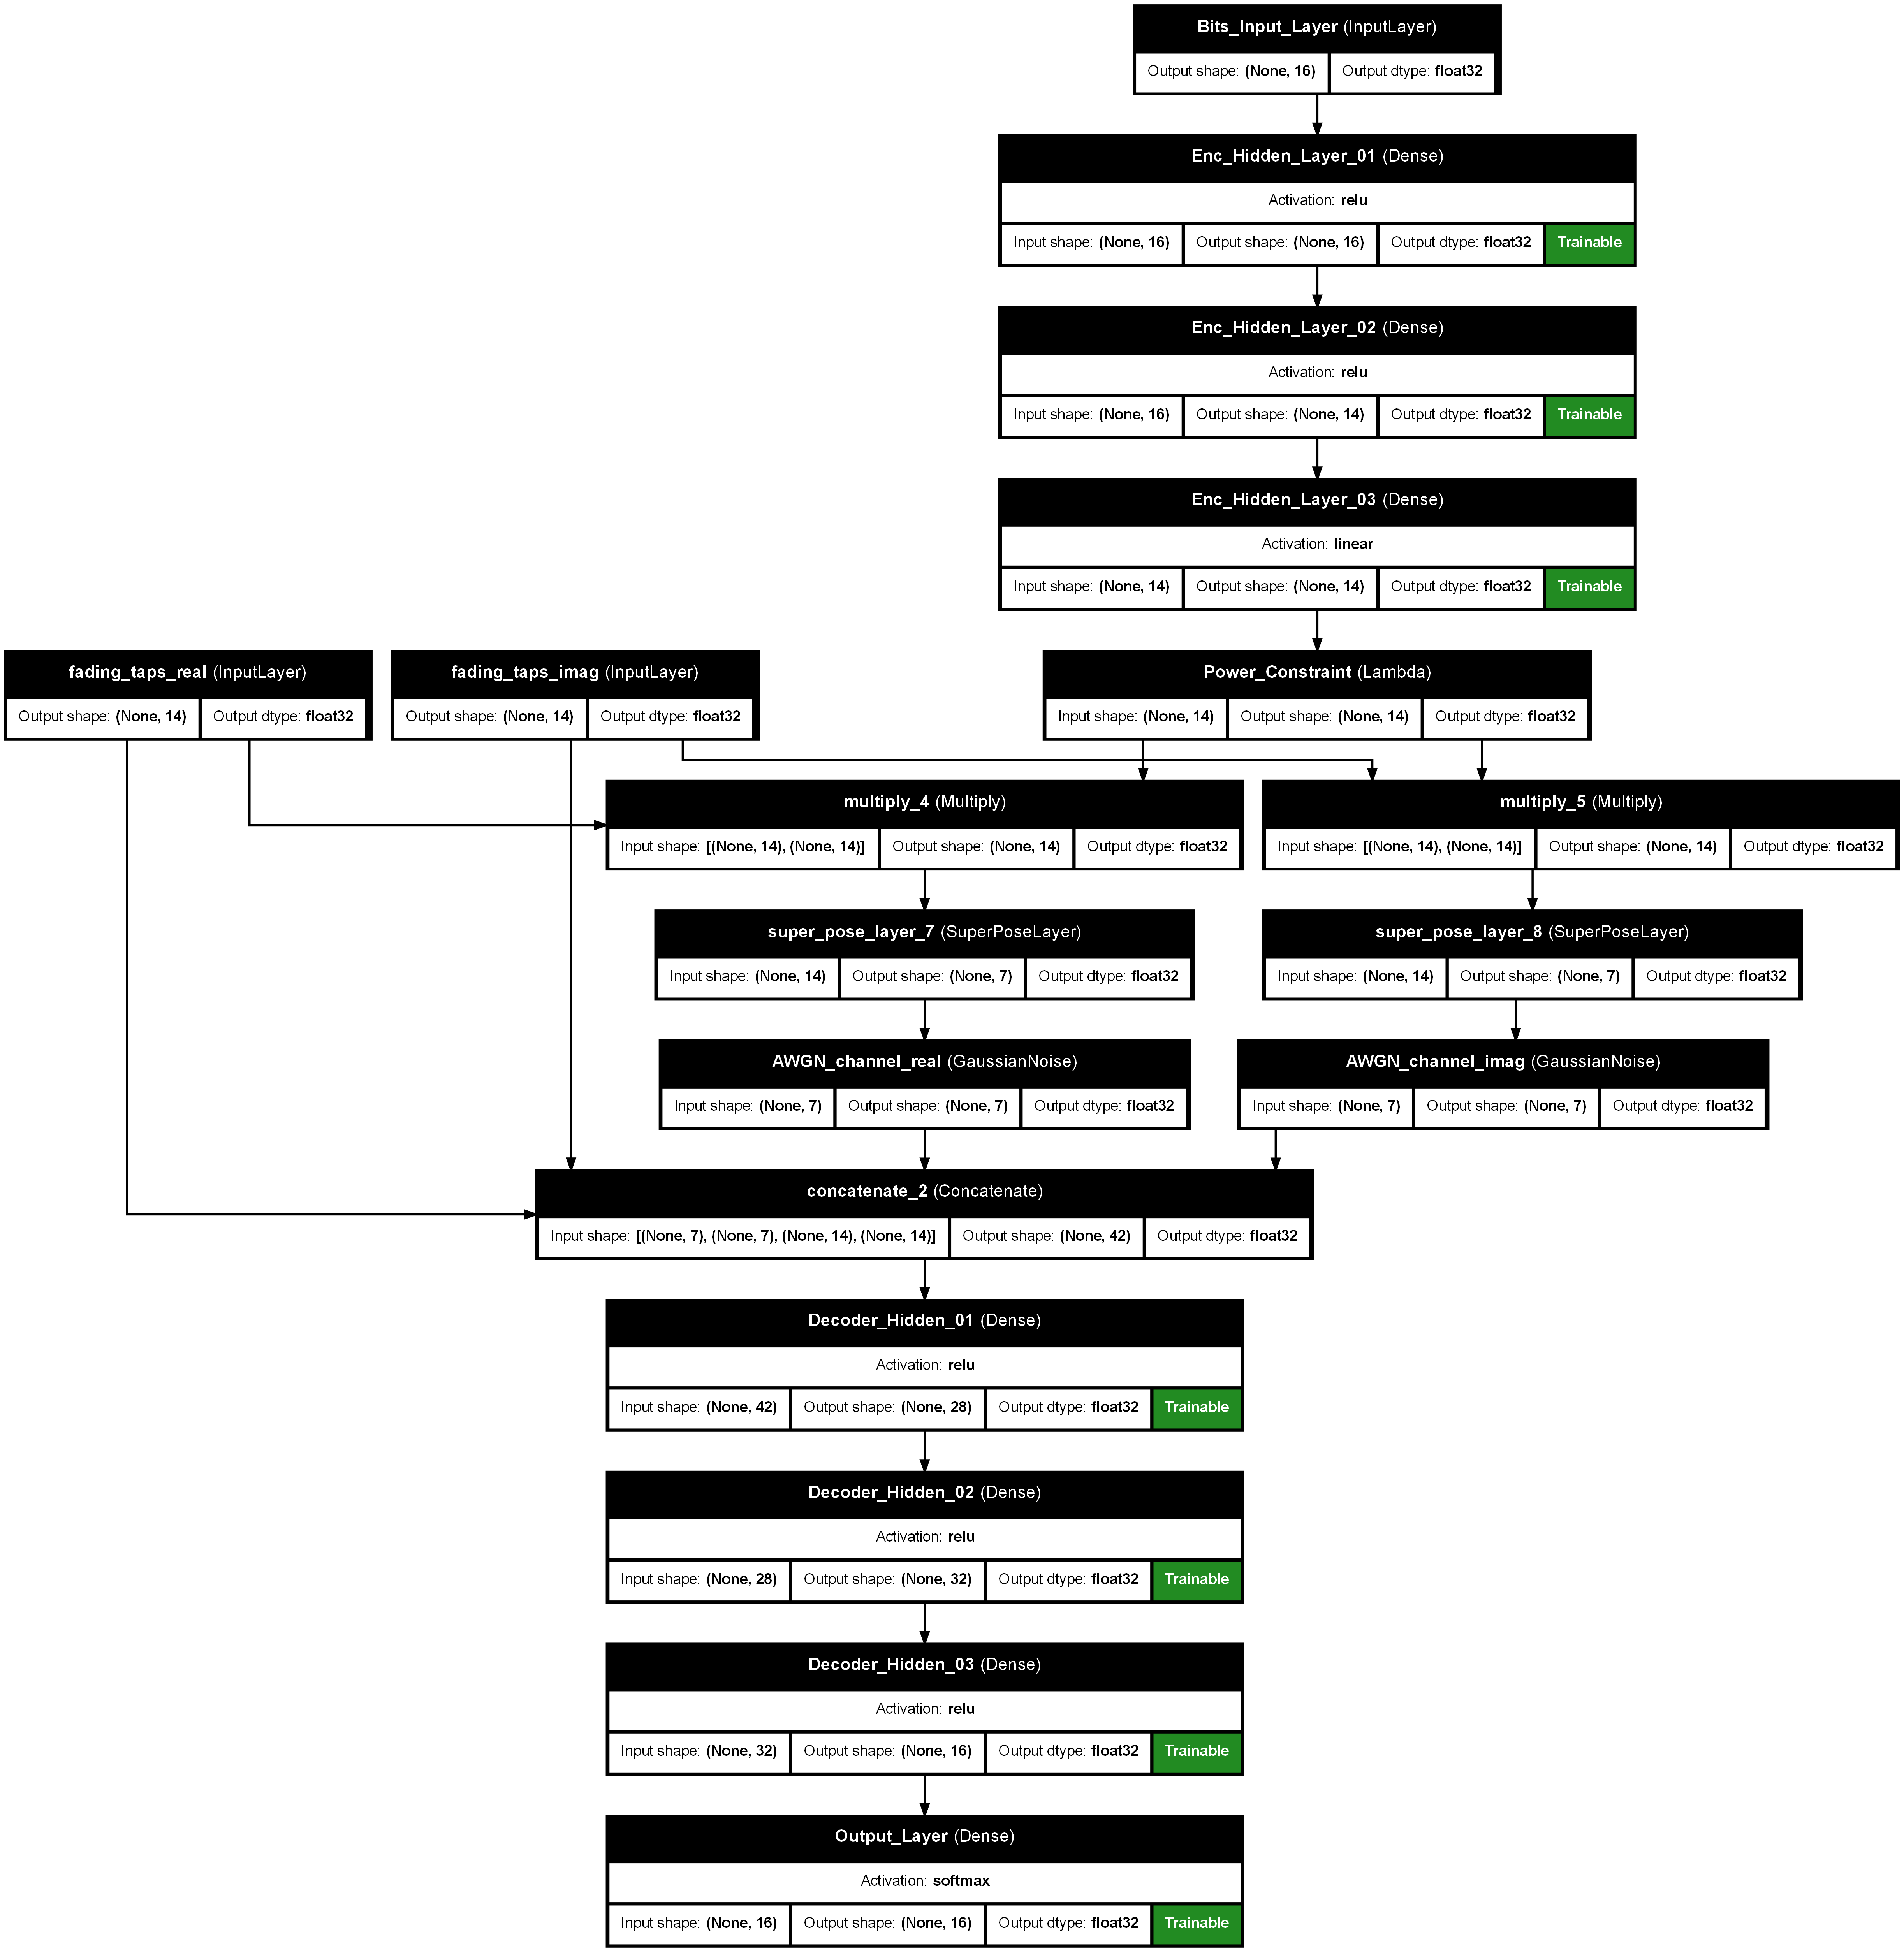

In [40]:
# Uncomment the following to view the block diagram of the neural network
tf.keras.utils.plot_model(
    autoencoder,
    to_file='deepMISO.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [41]:
autoencoder.fit([x_train, np.real(fade_taps), np.imag(fade_taps)], y_train, batch_size=1000, epochs=500)

Epoch 1/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3351 - loss: 1.8480
Epoch 2/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8806 - loss: 0.3321
Epoch 3/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9395 - loss: 0.1728
Epoch 4/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9547 - loss: 0.1298
Epoch 5/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9634 - loss: 0.1042
Epoch 6/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9690 - loss: 0.0880
Epoch 7/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9733 - loss: 0.0760
Epoch 8/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9761 - loss: 0.0674
Epoch 9/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9789 - loss: 0.0599
Epoch 10/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9812 - loss: 0.0537
Epoch 11/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9827 - loss: 0.0489
Epoch 12/500
1000/1

In [42]:
t1 = time.time()

> Testing the above learned system

In [43]:
# Creating the encoder :
encoder_model = tf.keras.Model(enc_input_layer_bits, enc_layer_normalized)

# Creating the decoder :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
fade_I = tf.keras.Input(shape=(2*n,))
fade_Q = tf.keras.Input(shape=(2*n,))
decoder_output = autoencoder.layers[-5]([rx_noisy_signal_I, rx_noisy_signal_Q, fade_I, fade_Q])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q, fade_I, fade_Q], decoder_output)

- Generation of validation data :

In [44]:
test_data_size = 10 ** 6
y_test = np.random.randint(0, M, test_data_size)
x_test = []
for idx in y_test:
    temp = np.zeros(M)
    temp[idx] = 1
    x_test.append(temp)

x_test = tf.constant(x_test)
x_test

<tf.Tensor: shape=(1000000, 16), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])>

- Validation Routine

In [45]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 

In [46]:
def split_and_add(array):
    # Check if the last dimension can be split into two equal parts
    if array.shape[-1] % 2 != 0:
        raise ValueError("Last dimension size must be even for splitting")

    # Split the last dimension into two halves
    half_size = array.shape[-1] // 2
    first_half = array[..., :half_size]
    second_half = array[..., half_size:]

    # Perform elementwise addition along the last dimension
    result = np.add(first_half, second_half)

    return result

In [47]:
BLER_learned_alamouti = []
count = 0 
for noise in noise_var :
    # Encoding using our model :
    encoded_signal = encoder_model.predict(x_test)
    # Fading :
    fade_taps = np.random.normal(fade_mean, fade_std, (test_data_size, 2*n)) + 1j * np.random.normal(fade_mean, fade_std, (test_data_size, 2*n))
    # Fast fading effect :
    rx_faded_signal = fade_taps * encoded_signal
    # Superposition : 
    rx_faded_signal = split_and_add(rx_faded_signal)
    noise_samples = np.random.normal(0, np.sqrt(noise), (test_data_size, n)) + 1j * np.random.normal(0, np.sqrt(noise), (test_data_size, n))
    rx_noisy_signal = rx_faded_signal + noise_samples 
    # Decoding using our model :
    decoded_signal = decoder_model.predict([np.real(rx_noisy_signal), np.imag(rx_noisy_signal), np.real(fade_taps), np.imag(fade_taps)])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_alamouti.append(np.sum(estimated_vectors != y_test) / test_data_size)
    # Progress Update :
    count += 1
    print(f'Progress : {100 * count // 30} %')

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step
Progress : 3 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step
Progress : 6 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step
Progress : 10 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step
Progress : 13 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step
Progress : 16 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 120s 4ms/step
Progress : 20 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step
Progress : 23 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 119s 4ms/step
Progress : 26 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step
Progress : 30 %
31250/31250 ━━━━━━━━━

- Visualizing the results 

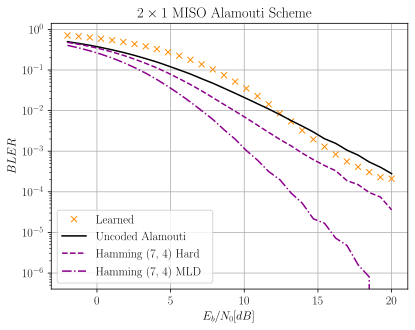

In [48]:
# Performance Benchmarks : Alamouti Coding Schemes  
BLER_uncoded_alamouti = [0.4966744, 0.4523544, 0.4058744, 0.3589288, 0.3133368, 0.2701856, 0.2287968, 0.1904096, 0.1571312, 0.1260232, 0.100364, 0.0795856, 0.0609912, 0.0472768, 0.0355496, 0.0267096, 0.019936, 0.0147448, 0.0109392, 0.0079712, 0.0056944, 0.0041464, 0.0029696, 0.0020232, 0.0015576, 0.0010632, 0.0008008, 0.0005416, 0.0004032, 0.00028]
BLER_coded_alamouti_hard = [0.4797672, 0.4304832, 0.3795744, 0.3282688, 0.2776816, 0.229624, 0.1851096, 0.1457968, 0.1126504, 0.0839472, 0.0611104, 0.0438328, 0.0306984, 0.0209032, 0.014176, 0.0096536, 0.0065352, 0.0043704, 0.0029088, 0.0019536, 0.001356, 0.0008968, 0.0006192, 0.0004432, 0.0003296, 0.0001888, 0.0001504, 9.6e-05, 7.44e-05, 3.6e-05]
BLER_coded_alamouti_mld = [0.4043976, 0.3504976, 0.296644, 0.245336, 0.1967608, 0.1529328, 0.1147504, 0.0835224, 0.0581632, 0.0392248, 0.0256336, 0.0162424, 0.010012, 0.006076, 0.0033944, 0.0019808, 0.0010416, 0.0006032, 0.0003152, 0.0001992, 9.36e-05, 5.28e-05, 2.16e-05, 1.68e-05, 7.2e-06, 4.8e-06, 1.6e-06, 8e-07, 0.0, 0.0]

plt.rcParams.update({
    "text.usetex": True, # Comment this line if TeX is not installed on your machine
    "font.family" : 'serif',
    "font.size": 12
})
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned_alamouti, label='Learned', color='darkorange', marker="x", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_alamouti, label='Uncoded Alamouti', color='black')
axes.semilogy(SNR_dB, BLER_coded_alamouti_hard, label='Hamming (7, 4) Hard', color='darkmagenta', ls="--")
axes.semilogy(SNR_dB, BLER_coded_alamouti_mld, label='Hamming (7, 4) MLD', color='darkmagenta', ls="-.")

axes.set_xlabel(r'$E_b / N_0[dB]$')
axes.set_ylabel(r'$BLER$')
axes.set_title(r'$2 \times 1$\ MISO Alamouti Scheme')
axes.legend()
axes.grid()

- Recording the results for future use :

In [49]:
# Saving the plots/ diagrams
fig.savefig(f'deepMISO_{int(SNR_train)}.svg', transparent=True)
# BLER values :
with open(f'deepMISO_{int(SNR_train)}.txt', mode='w') as file_id:
    file_id.write(f'BLER_uncoded_alamouti = {BLER_uncoded_alamouti}\n')
    file_id.write(f'BLER_coded_alamouti_hard = {BLER_coded_alamouti_hard}\n')
    file_id.write(f'BLER_coded_alamouti_mld = {BLER_coded_alamouti_mld}\n')
    file_id.write(f'BLER_learned_alamouti = {BLER_learned_alamouti}\n')

In [51]:
print(f'Total execution time = {time.time() - t0}')
print(f'Training time = {t1 - t0}')
print(f'Testing time = {time.time() - t1}')

Total execution time = 13497.392997264862
Training time = 5727.769716978073
Testing time = 7769.623280286789
